# Dataset ARE

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARE-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 3s 25ms/step - loss: 0.0882 - val_loss: 0.2334
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0865
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0821
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0738
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0579
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0459
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0324
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0218
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0127
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 11

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 5ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 2.7264498342345753
Testing RMSE: 2.722751919336784
Testing MAE: 1.9699552351137712
Validation MAE: 2.0827177803471404
Testing MAPE: 1.094916076863737
Validation MAPE: 1.4823991534007455


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.28811204]
2


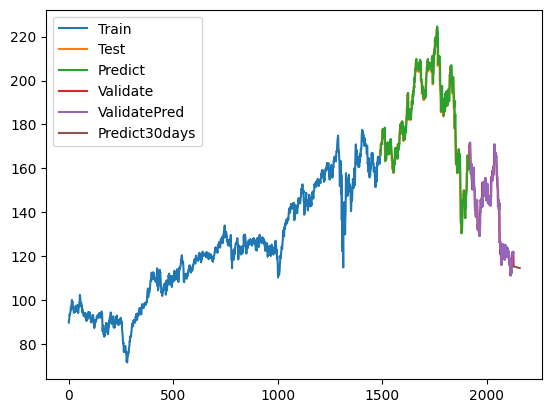

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[115.41998178],
       [115.39019037],
       [115.36062535],
       [115.3312867 ],
       [115.30217443],
       [115.27327496],
       [115.24458829],
       [115.21612799],
       [115.18788049],
       [115.15985031],
       [115.13203745],
       [115.10442834],
       [115.07704108],
       [115.0498485 ],
       [115.02287777],
       [114.99611531],
       [114.96955206],
       [114.94320614],
       [114.91705943],
       [114.89111193],
       [114.86536818],
       [114.83983269],
       [114.81448283],
       [114.78933219],
       [114.76436717],
       [114.73961495],
       [114.71505289],
       [114.69069005],
       [114.6665083 ],
       [114.64253482]])

# Dataset ARI

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARI-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 3s 25ms/step - loss: 0.2675 - val_loss: 0.0338
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0374 - val_loss: 0.0086
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0084 - val_loss: 0.0149
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0094
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0088
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0080
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0076
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0062
Epoch 11

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.2858304092111756
Testing RMSE: 0.2529928930039933
Testing MAE: 0.19701371375550625
Validation MAE: 0.205491248796571
Testing MAPE: 1.4740903212866308
Validation MAPE: 1.9483300803801153


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.45676708]
2


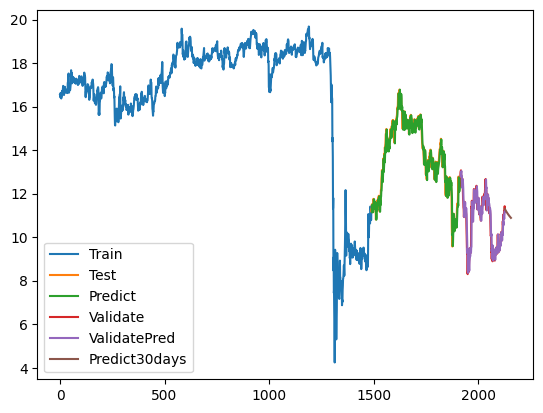

In [ ]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[11.29248375],
       [11.27521486],
       [11.25819077],
       [11.24141194],
       [11.22487514],
       [11.20858039],
       [11.19252537],
       [11.17670733],
       [11.16112442],
       [11.14577481],
       [11.13065849],
       [11.11577087],
       [11.10111102],
       [11.08667802],
       [11.07246773],
       [11.05848016],
       [11.04471115],
       [11.03115934],
       [11.01782287],
       [11.00470038],
       [10.99178817],
       [10.97908441],
       [10.96658541],
       [10.95429164],
       [10.94219849],
       [10.93030505],
       [10.91860763],
       [10.9071044 ],
       [10.89579488],
       [10.88467587]])

# Dataset MAA

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('MAA-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
24/24 [==============================] - 4s 28ms/step - loss: 0.0207 - val_loss: 0.1737
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0073 - val_loss: 0.1504
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0057 - val_loss: 0.1277
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0970
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0697
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0476
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0270
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0142
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 5.6967e-04 - val_loss: 0.0059
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 3.1202e-04 - val_loss: 0.0019


In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

7/7 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 2.642094814399592
Testing RMSE: 2.625374767761048
Testing MAE: 2.0039373418568998
Validation MAE: 2.0262790032152864
Testing MAPE: 1.112868363884046
Validation MAPE: 1.2864229041158426


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[213:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.53083354]
2


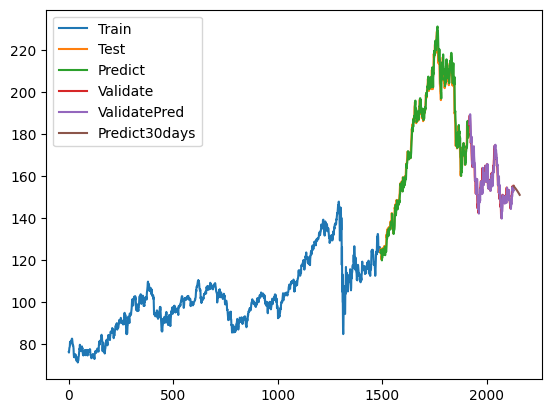

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[155.17564142],
       [155.05950823],
       [154.94159186],
       [154.82185457],
       [154.70024918],
       [154.57681344],
       [154.45146243],
       [154.32420559],
       [154.19500518],
       [154.06384232],
       [153.93068872],
       [153.79553493],
       [153.65835266],
       [153.51912303],
       [153.37781775],
       [153.23439906],
       [153.08886697],
       [152.94118375],
       [152.79133051],
       [152.63927897],
       [152.48501024],
       [152.32848659],
       [152.16971745],
       [152.00866508],
       [151.84529176],
       [151.67957859],
       [151.51151616],
       [151.34105728],
       [151.16821139],
       [150.99293132]])